In [1]:
import os
import sys
import glob
import scipy
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib widget

import collections
from collections import namedtuple
import builtins
import csv
import math

c:\Users\OppersmaE\Anaconda3\envs\julytry5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get the parent directory of the script
#current_dir = os.path.dirname(os.path.realpath(__file__))
#parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

sys.path.insert(0, '..')
from resurfemg.postprocessing import baseline
from resurfemg.config.config import Config
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat

# Add the parent directory to the Python path
#sys.path.append(parent_dir)

In [12]:
from scipy.io import loadmat
mat_file = r'M:\Documents\CRPH\Supervisie\Farnaz Soleimani\matlab\nightdata.mat'
data = loadmat(mat_file)


nightdata = data['tempData']


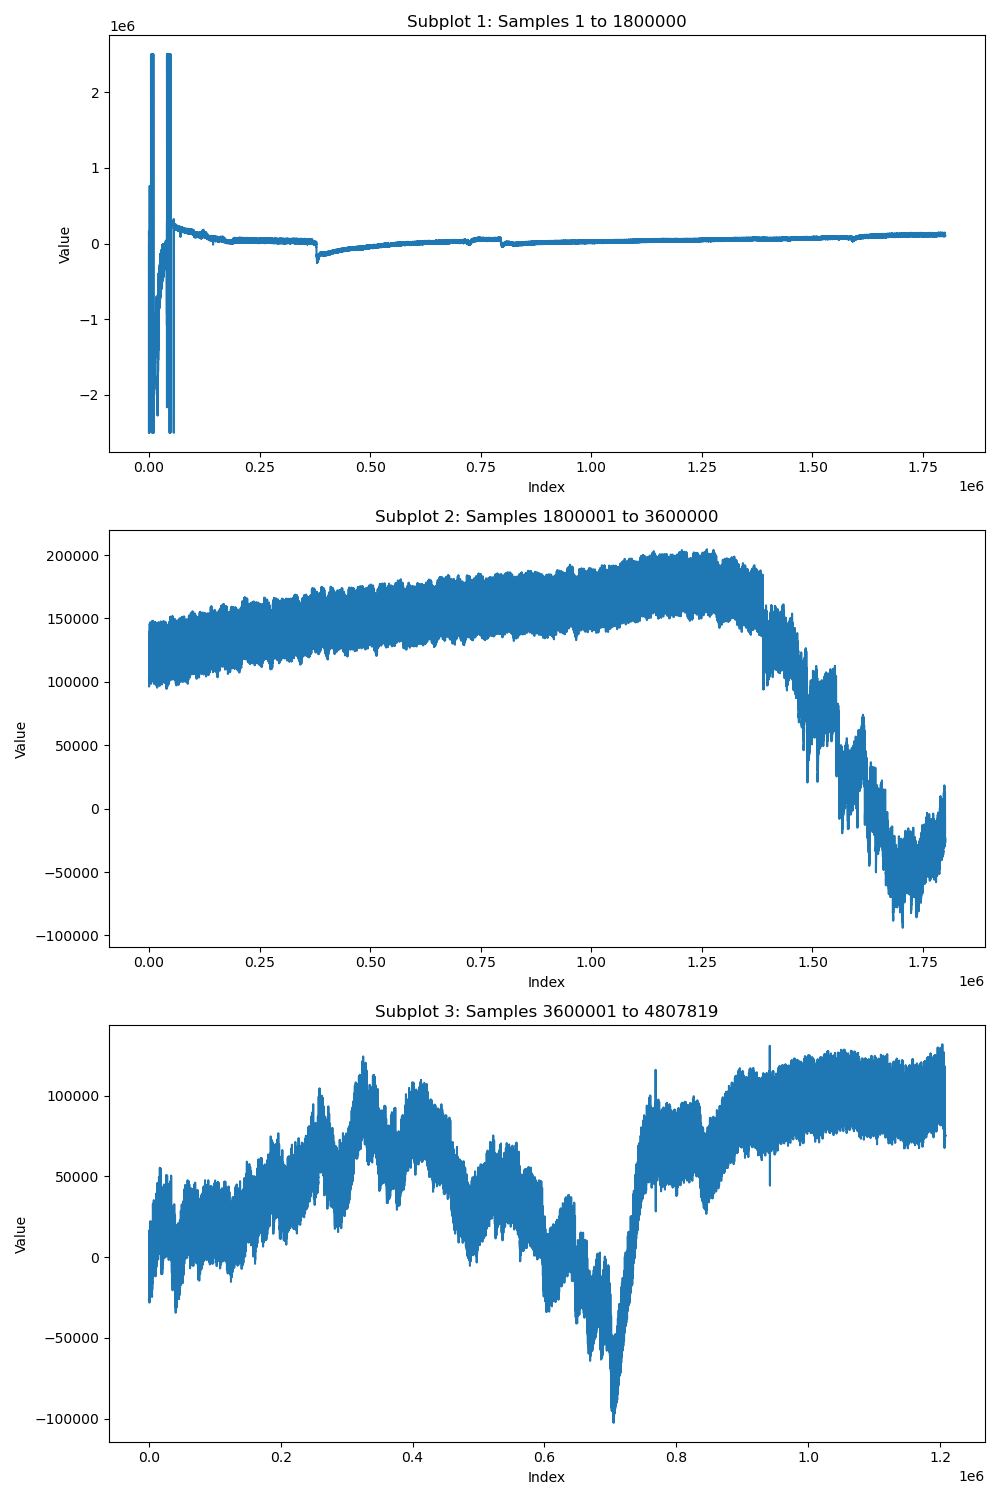

In [24]:
samples_per_subplot = 1800000

num_subplots = (nightdata.shape[1] // samples_per_subplot) + 1

fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots*5))

# Iterate over each subplot
for i in range(num_subplots):
    # Calculate start and end indices for current subplot
    start_index = i * samples_per_subplot
    end_index = min((i + 1) * samples_per_subplot, nightdata.shape[1])

    # Extract the subset of data for current subplot
    subset_data = nightdata[0, start_index:end_index]

    # Plot the subset of data
    axs[i].plot(subset_data)

    # Add labels and title to the subplot
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Subplot {i+1}: Samples {start_index+1} to {end_index}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [25]:
low_freq=80
high_freq=450
sample_rate=1000
emg_data_filtered = filt.emg_bandpass_butter_sample(nightdata,low_freq, high_freq, sample_rate)
#plt.figure(figsize=(12,2))
#plt.plot(emg_data_filtered[2])

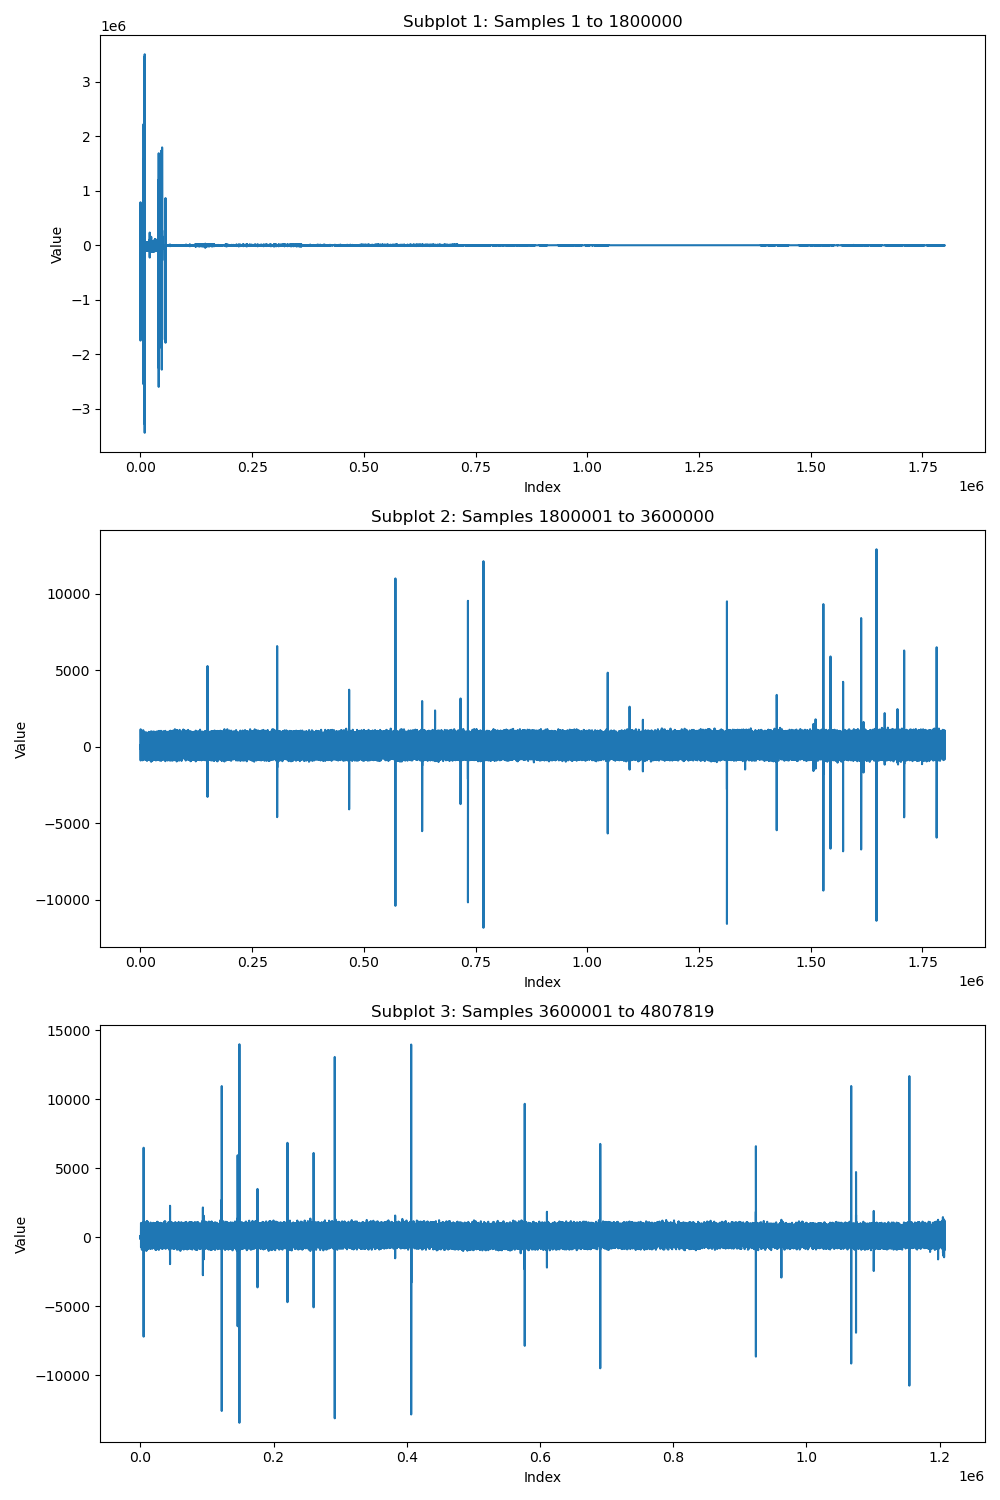

In [28]:
fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots*5))

# Iterate over each subplot
for i in range(num_subplots):
    # Calculate start and end indices for current subplot
    start_index = i * samples_per_subplot
    end_index = min((i + 1) * samples_per_subplot, emg_data_filtered.shape[1])

    # Extract the subset of data for current subplot
    subset_data = emg_data_filtered[0, start_index:end_index]

    # Plot the subset of data
    axs[i].plot(subset_data)

    # Add labels and title to the subplot
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Subplot {i+1}: Samples {start_index+1} to {end_index}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


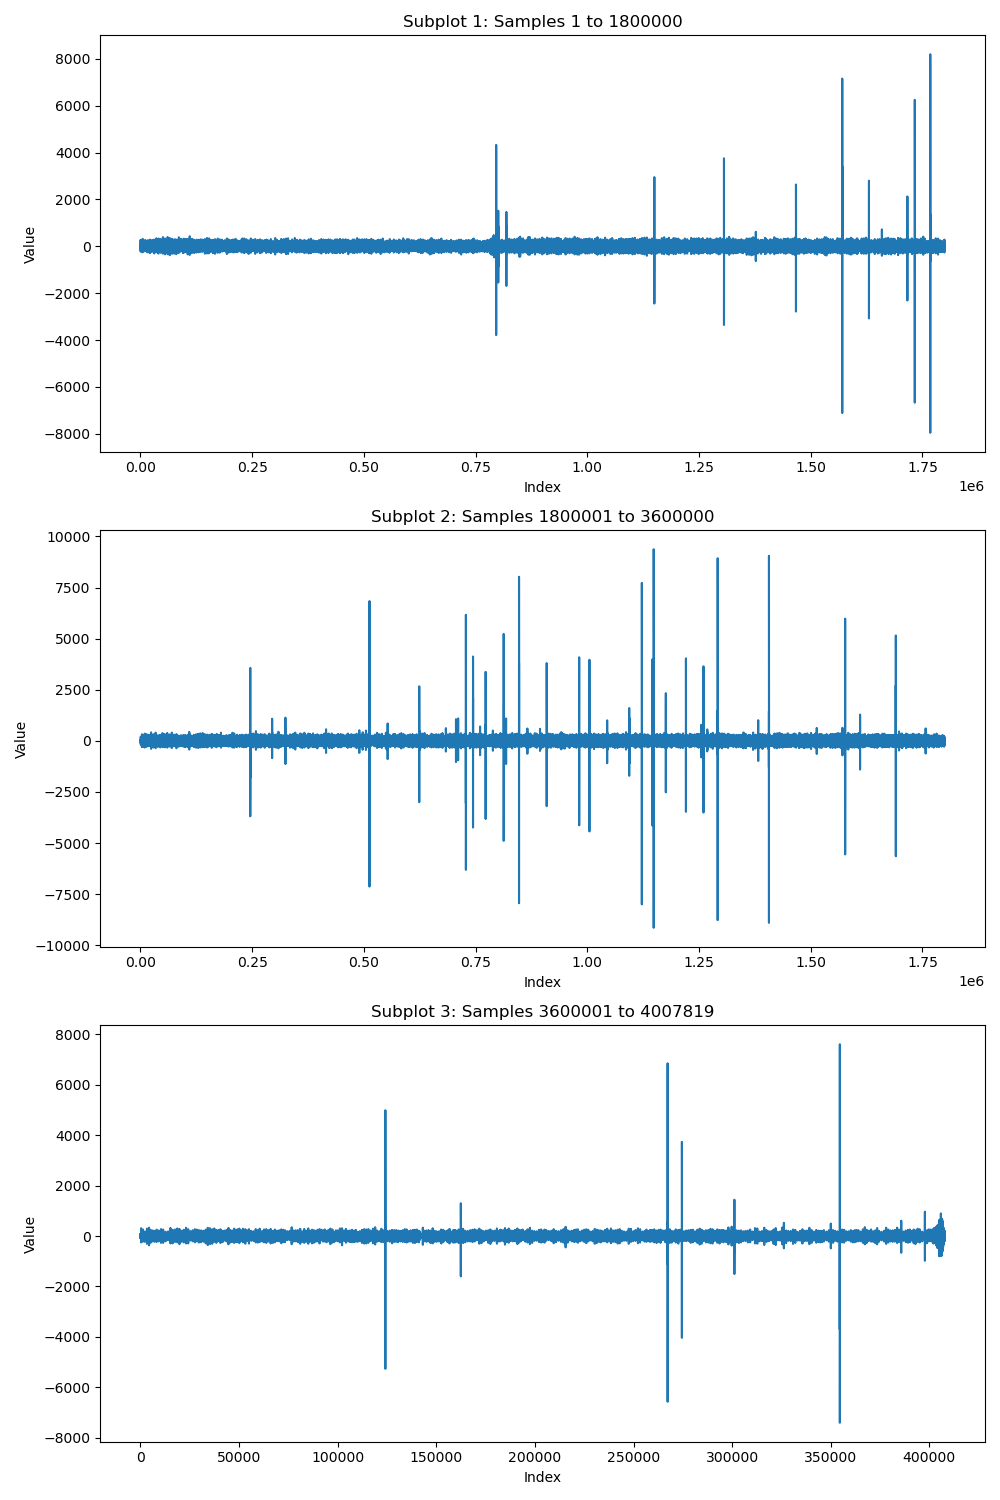

In [70]:
emg_data_filtered_new=emg_data_filtered[0,800000:4807819]
emg_data_filtered2=filt.emg_highpass_butter_sample(emg_data_filtered_new,200,1000)
samples_per_subplot=1800000
num_subplots = (emg_data_filtered2.shape[0] // samples_per_subplot) + 1

fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots*5))

# Iterate over each subplot
for i in range(num_subplots):
    # Calculate start and end indices for current subplot
    start_index = i * samples_per_subplot
    end_index = min((i + 1) * samples_per_subplot, emg_data_filtered2.shape[0])

    # Extract the subset of data for current subplot
    subset_data = emg_data_filtered2[start_index:end_index]

    # Plot the subset of data
    axs[i].plot(subset_data)

    # Add labels and title to the subplot
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Subplot {i+1}: Samples {start_index+1} to {end_index}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

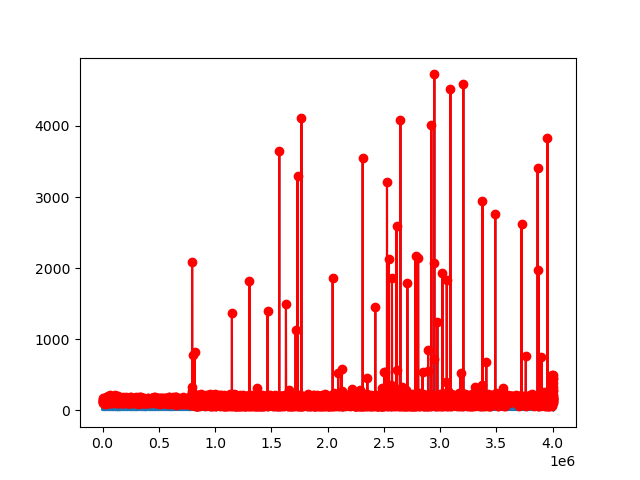

In [71]:

emg_ecg = []
titles = []
gating_method=3
# 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
peak_width = 0.01
peak_fraction = 0.40
ecg_rms = evl.full_rolling_rms(emg_data_filtered2, 10)
peak_height = peak_fraction * (max(ecg_rms[0:1000]) - min(ecg_rms[0:1000]))
ecg_peaks, _ = find_peaks(ecg_rms, height=peak_height,width=peak_width * sample_rate, distance=int(sample_rate / 3))

plt.figure()
plt.plot(ecg_rms)
plt.plot(ecg_peaks, ecg_rms[ecg_peaks], c='r', marker='o', label='Detected Peaks')
#plt.xlim(0,1800000)

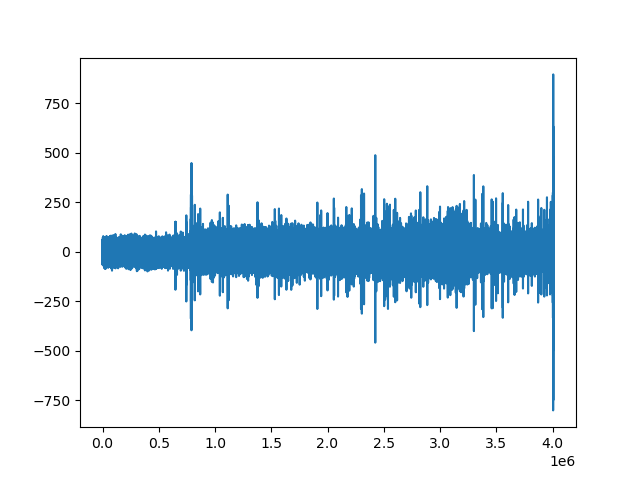

In [77]:
emg_clean = ecg_rm.gating(emg_data_filtered2, ecg_peaks, gate_width=100, method=0)
emg_clean = np.array(emg_clean)

plt.figure()
plt.plot(emg_clean)


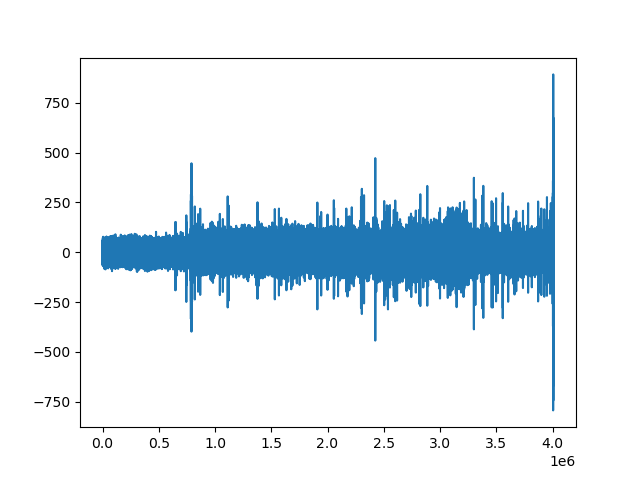

In [78]:
emg_data_filtered3 = filt.emg_bandpass_butter_sample(emg_clean,80, 450, 1000)
plt.figure()
plt.plot(emg_data_filtered3)

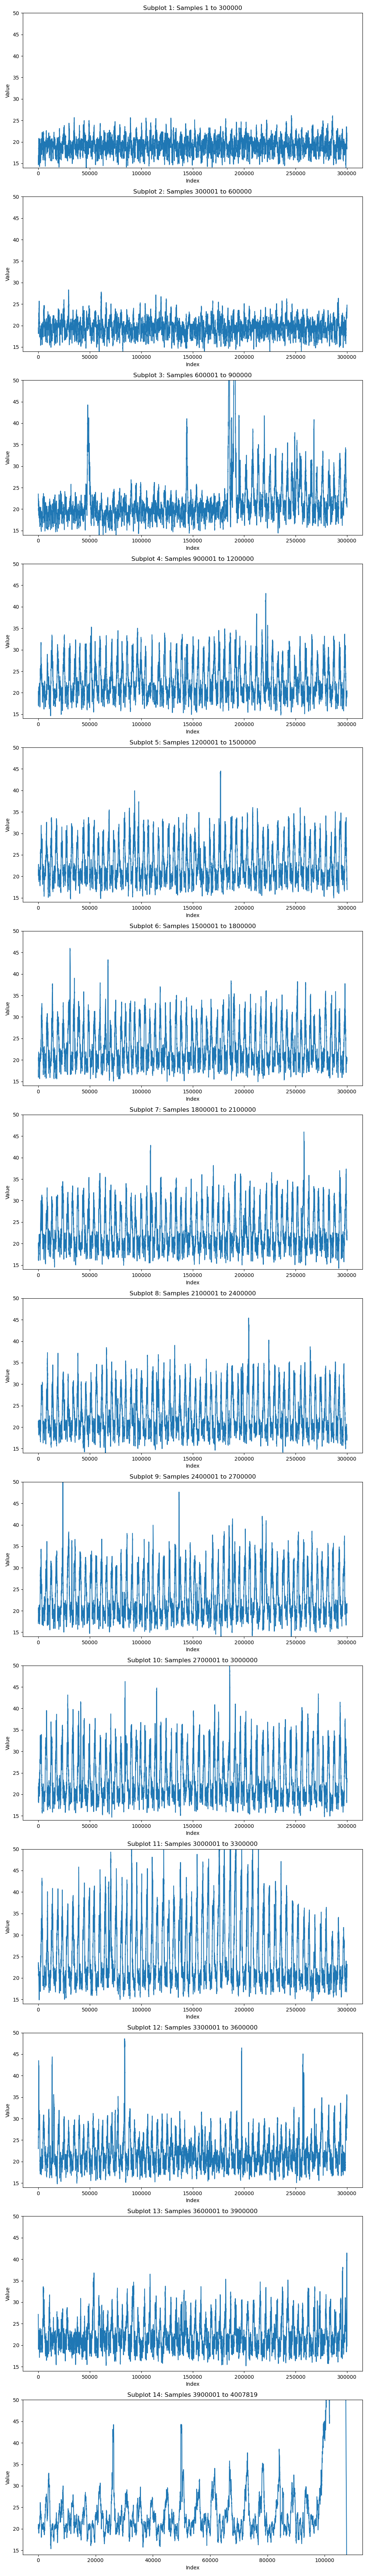

In [86]:
emg_env = evl.full_rolling_rms(abs(emg_clean), 400)

samples_per_subplot=300*1000
num_subplots = (emg_clean.shape[0] // samples_per_subplot) + 1

fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots*5))

# Iterate over each subplot
for i in range(num_subplots):
    # Calculate start and end indices for current subplot
    start_index = i * samples_per_subplot
    end_index = min((i + 1) * samples_per_subplot, emg_clean.shape[0])

    # Extract the subset of data for current subplot
    subset_data = emg_env[start_index:end_index]

    # Plot the subset of data
    axs[i].plot(subset_data)

    # Add labels and title to the subplot
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Subplot {i+1}: Samples {start_index+1} to {end_index}')
    axs[i].set_ylim(14, 50)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
low_freq=80
high_freq=450
sample_rate=1000
emg_data_filtered = filt.emg_bandpass_butter_sample(nightdata,low_freq, high_freq, sample_rate)
#plt.figure(figsize=(12,2))
#plt.plot(emg_data_filtered[2])